In [1]:
#import needed packages

import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
import time
import pandas as pd
from ecp import e_divisive, e_agglomerative
%matplotlib inline

In [33]:
def get_within(alpha, X):
    alpha = float(alpha)
    ret = 0.0
    n = X.shape[0]

    Xprime = X.reshape(n, 1, X.shape[1])
    ret = np.sum(np.power(np.sqrt(np.einsum('ijk, ijk->ij', X-Xprime, X-Xprime)), alpha))
    return ret/(n*n)
        
def get_between(alpha, X, Y):
    alpha = float(alpha)
    ret = 0.0
    n = X.shape[0]
    m = Y.shape[0]

    X = X.reshape(X.shape[0], 1, X.shape[1])
    ret = np.sum(np.power(np.sqrt(np.einsum('ijk, ijk->ij', X-Y, X-Y)), alpha))
    return (2*ret)/float(n*m)

# alpha = alpha
# ts = ts
# n = len(sol_dict['estimates'])-1
# cluster = sol_dict['cluster']
# k = stopping condition (num_of_states)
def agglo_method(alpha, n, ts, cluster, k):
    ret = {"order": [], "cluster": cluster}
    curr_n = n
    if curr_n <= k:
        return ret
    
    within = np.zeros(n)
    for i in range(n):
        working_ts = ts[cluster==i]
        within[i] = get_within(alpha, np.reshape(working_ts, (len(working_ts), 1)))

    dflat = np.zeros(int(((n*n)-n)/2))
    idx = 0
    md = [] #maps from the linear index to the tuple (i, j) in the non-flattened distance matrix

    for i in range(n):
        for j in range(i+1, n):
            working_ts1 = ts[cluster==i]
            working_ts2 = ts[cluster==j]
            d = get_between(alpha, np.reshape(working_ts1, (len(working_ts1), 1)), np.reshape(working_ts2, (len(working_ts2), 1))) - within[i] - within[j]
            dflat[idx] = d
            idx += 1
            md.append((i, j))
    while(curr_n > k):
        min_idx = np.nanargmin(dflat)
        i, j = md[min_idx]
        ret["order"].append((i, j))
        
        
        cluster[cluster==j] = i
        working_ts = ts[cluster == i]
        new_within = get_within(alpha, np.reshape(working_ts, (len(working_ts), 1)))
        within[i] = new_within
        within[j] = new_within
        
        for idx in range(n):
            if idx != j and idx != i:
                working_ts1 = ts[cluster==i]
                working_ts2 = ts[cluster==idx]
                d = get_between(alpha, np.reshape(working_ts1, (len(working_ts1), 1)), np.reshape(working_ts2, (len(working_ts2), 1))) - within[i] - within[idx]
                
                if idx < i:
                    flat_idx = int(((2*idx*n) - (idx*idx) + (2*i) - (3*idx) - 2)/2)
                    dflat[flat_idx] = d
                elif idx > i:
                    flat_idx = int(((2*i*n) - (i*i) + (2*idx) - (3*i) - 2)/2)
                    dflat[flat_idx] = d
                    
                if idx < j:
                    flat_idx = int(((2*idx*n) - (idx*idx) + (2*j) - (3*idx) - 2)/2)
                    dflat[flat_idx] = np.inf
                elif idx > j:
                    flat_idx = int(((2*j*n) - (j*j) + (2*idx) - (3*j) - 2)/2)
                    dflat[flat_idx] = np.inf
            elif idx == j:
                t1, t2 = (i, j) if i < j else (j, i)
                flat_idx = int(((2*t1*n) - (t1*t1) + (2*t2) - (3*t1) - 2)/2)
                dflat[flat_idx] = np.inf  
                
                flat_idx = int(((2*t2*n) - (t2*t2) + (2*t1) - (3*t2) - 2)/2)
                dflat[flat_idx] = np.inf
        curr_n = len(np.unique(cluster))
    ret["cluster"] = cluster
    return ret

In [55]:
def get_within2(alpha, X):
    alpha = float(alpha)
    ret = 0.0
    
    n = X.shape[0]
    
    for i in range(n):
        for j in range(n):
            ret += np.power(np.sqrt(np.sum((X[i, :] - X[j, :]) * (X[i, :] - X[j, :]))), alpha)
    return ret/(n*n) if (n*n) != 0 else np.nan

def get_between2(alpha, X, Y):
    alpha = float(alpha)
    ret = 0.0
    
    n = X.shape[0]
    m = Y.shape[0]
    
    for i in range(n):
        for j in range(m):
            ret += np.power(np.sqrt(np.sum((X[i, :] - Y[j, :]) * (X[i, :] - Y[j, :]))), alpha)
    return (2*ret)/float(n*m) if (n*m) != 0 else np.nan

def agglo_method2(alpha, n, ts, cluster, k):
    ret = {"order": [], "cluster": cluster}
    curr_n = n
    if curr_n <= k:
        return ret
    
    within = np.zeros(n)
    for i in range(n):
        working_ts = ts[cluster==i]
        if working_ts.ndim == 1: working_ts = np.reshape(working_ts, (len(working_ts), 1))
        within[i] = get_within2(alpha, working_ts)

    dflat = np.zeros(int(((n*n)-n)/2))
    idx = 0
    md = [] #maps from the linear index to the tuple (i, j) in the non-flattened distance matrix

    for i in range(n):
        for j in range(i+1, n):
            working_ts1 = ts[cluster==i]
            working_ts2 = ts[cluster==j]
            if working_ts1.ndim == 1: working_ts1 = np.reshape(working_ts1, (len(working_ts1), 1))
            if working_ts2.ndim == 1: working_ts2 = np.reshape(working_ts2, (len(working_ts2), 1))
            d = get_between2(alpha, working_ts1, working_ts2) - within[i] - within[j]
            dflat[idx] = d
            idx += 1
            md.append((i, j))
    while(curr_n > k):
        min_idx = np.nanargmin(dflat)
        i, j = md[min_idx]
        ret["order"].append((i, j))
        
        
        cluster[cluster==j] = i
        working_ts = ts[cluster == i]
        if working_ts.ndim == 1: working_ts = np.reshape(working_ts, (len(working_ts), 1))
        new_within = get_within2(alpha, working_ts)
        within[i] = new_within
        within[j] = new_within
        
        for idx in range(n):
            if idx != j and idx != i:
                working_ts1 = ts[cluster==i]
                working_ts2 = ts[cluster==idx]
                if working_ts1.ndim == 1: working_ts1 = np.reshape(working_ts1, (len(working_ts1), 1))
                if working_ts2.ndim == 1: working_ts2 = np.reshape(working_ts2, (len(working_ts2), 1))
                d = get_between2(alpha, working_ts1, working_ts2) - within[i] - within[idx]
                
                if idx < i:
                    flat_idx = int(((2*idx*n) - (idx*idx) + (2*i) - (3*idx) - 2)/2)
                    dflat[flat_idx] = d
                elif idx > i:
                    flat_idx = int(((2*i*n) - (i*i) + (2*idx) - (3*i) - 2)/2)
                    dflat[flat_idx] = d
                    
                if idx < j:
                    flat_idx = int(((2*idx*n) - (idx*idx) + (2*j) - (3*idx) - 2)/2)
                    dflat[flat_idx] = np.inf
                elif idx > j:
                    flat_idx = int(((2*j*n) - (j*j) + (2*idx) - (3*j) - 2)/2)
                    dflat[flat_idx] = np.inf
            elif idx == j:
                t1, t2 = (i, j) if i < j else (j, i)
                flat_idx = int(((2*t1*n) - (t1*t1) + (2*t2) - (3*t1) - 2)/2)
                dflat[flat_idx] = np.inf  
                
                flat_idx = int(((2*t2*n) - (t2*t2) + (2*t1) - (3*t2) - 2)/2)
                dflat[flat_idx] = np.inf
        curr_n = len(np.unique(cluster))
    ret["cluster"] = cluster
    return ret

In [10]:
def mkv_to_ts(P, S, sigma = 1, n = 1000, debug=False):
    k = len(S)
    base_matrix = np.tile(S, (n, 1)).T
    noise_matrix = np.random.normal(0, sigma, (k, n))
    full_matrix = base_matrix + noise_matrix
    
    state_gen = np.empty(n, dtype = np.int32)
    state_gen[0] = 0
    for i in range(1, n):
        state_gen[i] = np.random.choice(k, p=P[state_gen[i-1]])
    return state_gen if debug else np.choose(state_gen, full_matrix)

P = np.array([[0.95, 0.02, 0.03],
              [0.01, 0.95, 0.04],
              [0.03, 0.03, 0.94]])
S = np.array([-5, 0, 5])

N = 500
K = int(N/(1/(1 - P[0, 0]))) + N/100
ms = 2
num_of_states = len(S)

ts = mkv_to_ts(P, S, n=N)

t1 = time.time()
sol_dict = e_divisive.e_divisive(X = np.reshape(ts, (len(ts), 1)), k=K, alpha=2, min_size=ms)
t2 = time.time()

In [14]:
point_labels = agglo_method(alpha=2, n=len(sol_dict['estimates'])-1, ts=np.copy(ts), cluster=np.copy(sol_dict['cluster']), k=num_of_states)["cluster"]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


/Users/ethangoolish/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/ethangoolish/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


In [12]:
print(point_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 0 0 0 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2
 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [25]:
point_labels2 = agglo_method2(alpha=2, n=len(sol_dict['estimates'])-1, ts=np.copy(ts), cluster=np.copy(sol_dict['cluster']), k=num_of_states)["cluster"]

In [26]:
print(point_labels2)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 0 0 0 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2
 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [29]:
print(all(point_labels == point_labels2))

True
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  1  1  1  1  1  1  1  1  1  1  1  1  2  2  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  4  4  5  5  5  6  6  6  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 11 11 11 12 12 12 12 12 13 13 13 13 13
 13 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 15 15 15 15 15 15 15 16 16 16 16 16 17 17 17 17 18 18 18
 18 18 18 18 18 18 18 18 18 19 19 19 20 20 20 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 8 8 8
 8 8 8 8 8 8 8 8 8 8 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 0 0 0 0 0 0 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 8 8 8 8 8 8 8 8 8 8 8 8 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 8 8 8 8 8 8 8 8 8 8 8 8 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

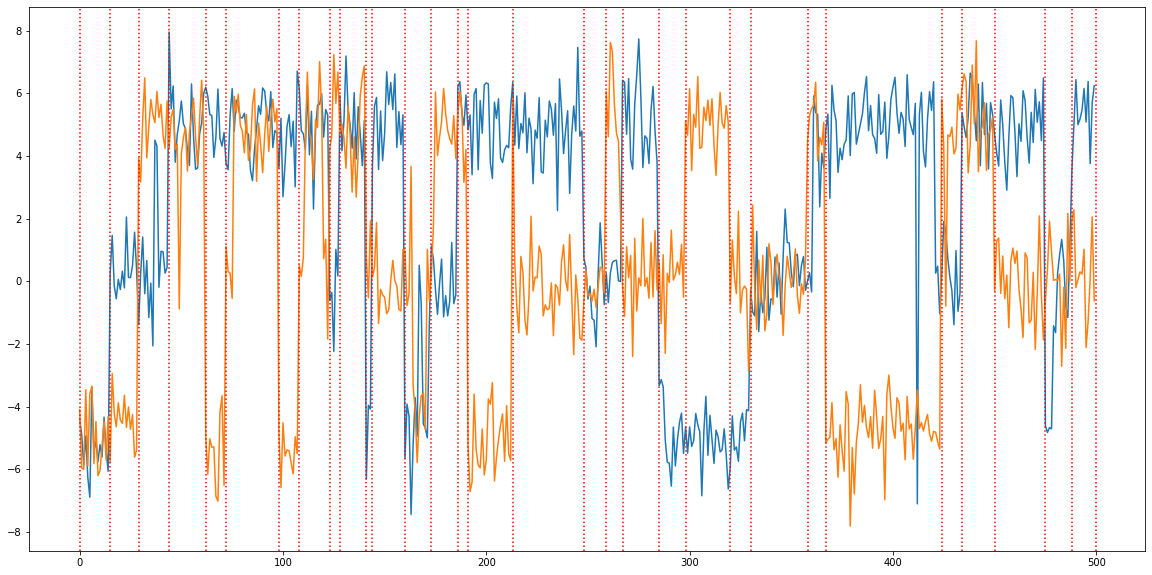

In [59]:
P = np.array([[0.95, 0.02, 0.03],
              [0.01, 0.95, 0.04],
              [0.03, 0.03, 0.94]])
S = np.array([-5, 0, 5])

N = 500
K = int(N/(1/(1 - P[0, 0]))) + N/100
ms = 2
num_of_states = len(S)

ts1 = mkv_to_ts(P, S, n=N)
ts2 = mkv_to_ts(P, S, n=N)
ts = np.stack((ts1, ts2), axis=-1)

t1 = time.time()
sol_dict = e_divisive.e_divisive(X = ts, k=K, alpha=2, min_size=ms)
t2 = time.time()

plt.figure(figsize=(20,10))
plt.plot(ts)
for xc in sol_dict['estimates']:
    plt.axvline(x=xc, color='r', linestyle=':')


# am = agglo_method(alpha = 2, n = n-2, ts = np.copy(ts), cluster = clus, k =3)
cluster_labels = agglo_method2(alpha=2, n=len(sol_dict['estimates'])-1, ts=np.copy(ts), cluster=np.copy(sol_dict['cluster']), k=num_of_states)["cluster"]
# print(am)
print(am2)

[0, 15, 29, 62, 72, 98, 108, 191, 213, 367, 424, 500]


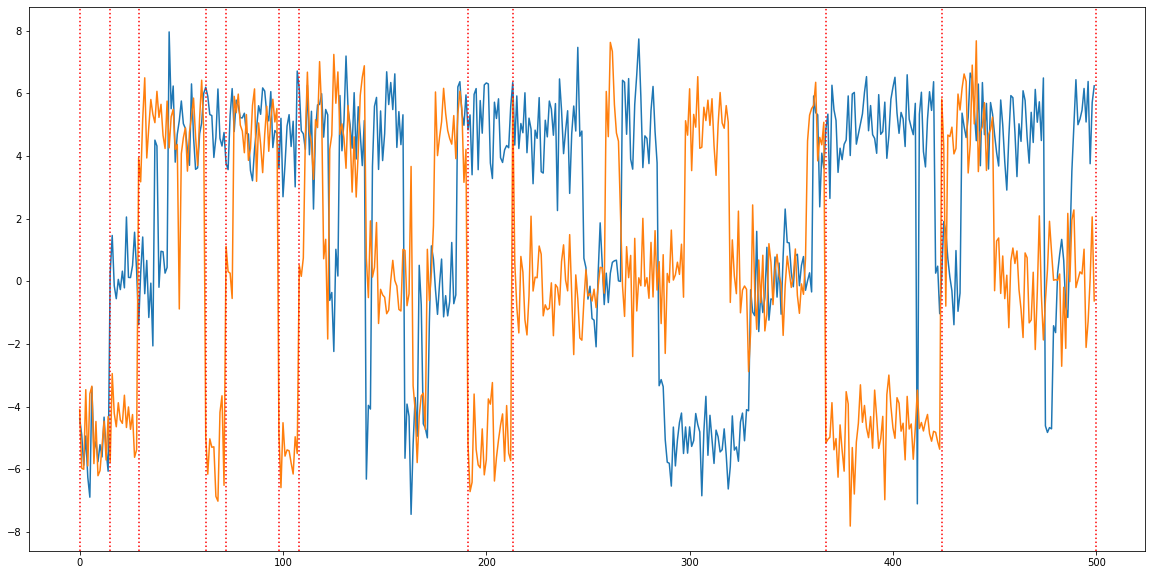

In [60]:
new_ests = [sol_dict['estimates'][0]]
for i in range(1, len(cluster_labels)):
    if cluster_labels[i] != cluster_labels[i-1]:
        new_ests.append(i)
new_ests.append(sol_dict['estimates'][-1])

print(new_ests)
plt.figure(figsize=(20,10))
plt.plot(ts)
for xc in new_ests:
    plt.axvline(x=xc, color='r', linestyle=':')